# In this notebook, we will implement a Conditional Variational Autoencoder (CVAE) for the MNIST dataset and then unlearn a specific digit using the method mentioned in the paper [Selective Amnesia: A Continual Learning Approach for Forgetting in Deep Generative Models](https://arxiv.org/abs/2305.13990).

## Imports

In [1]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import tqdm

## Data Preparation

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

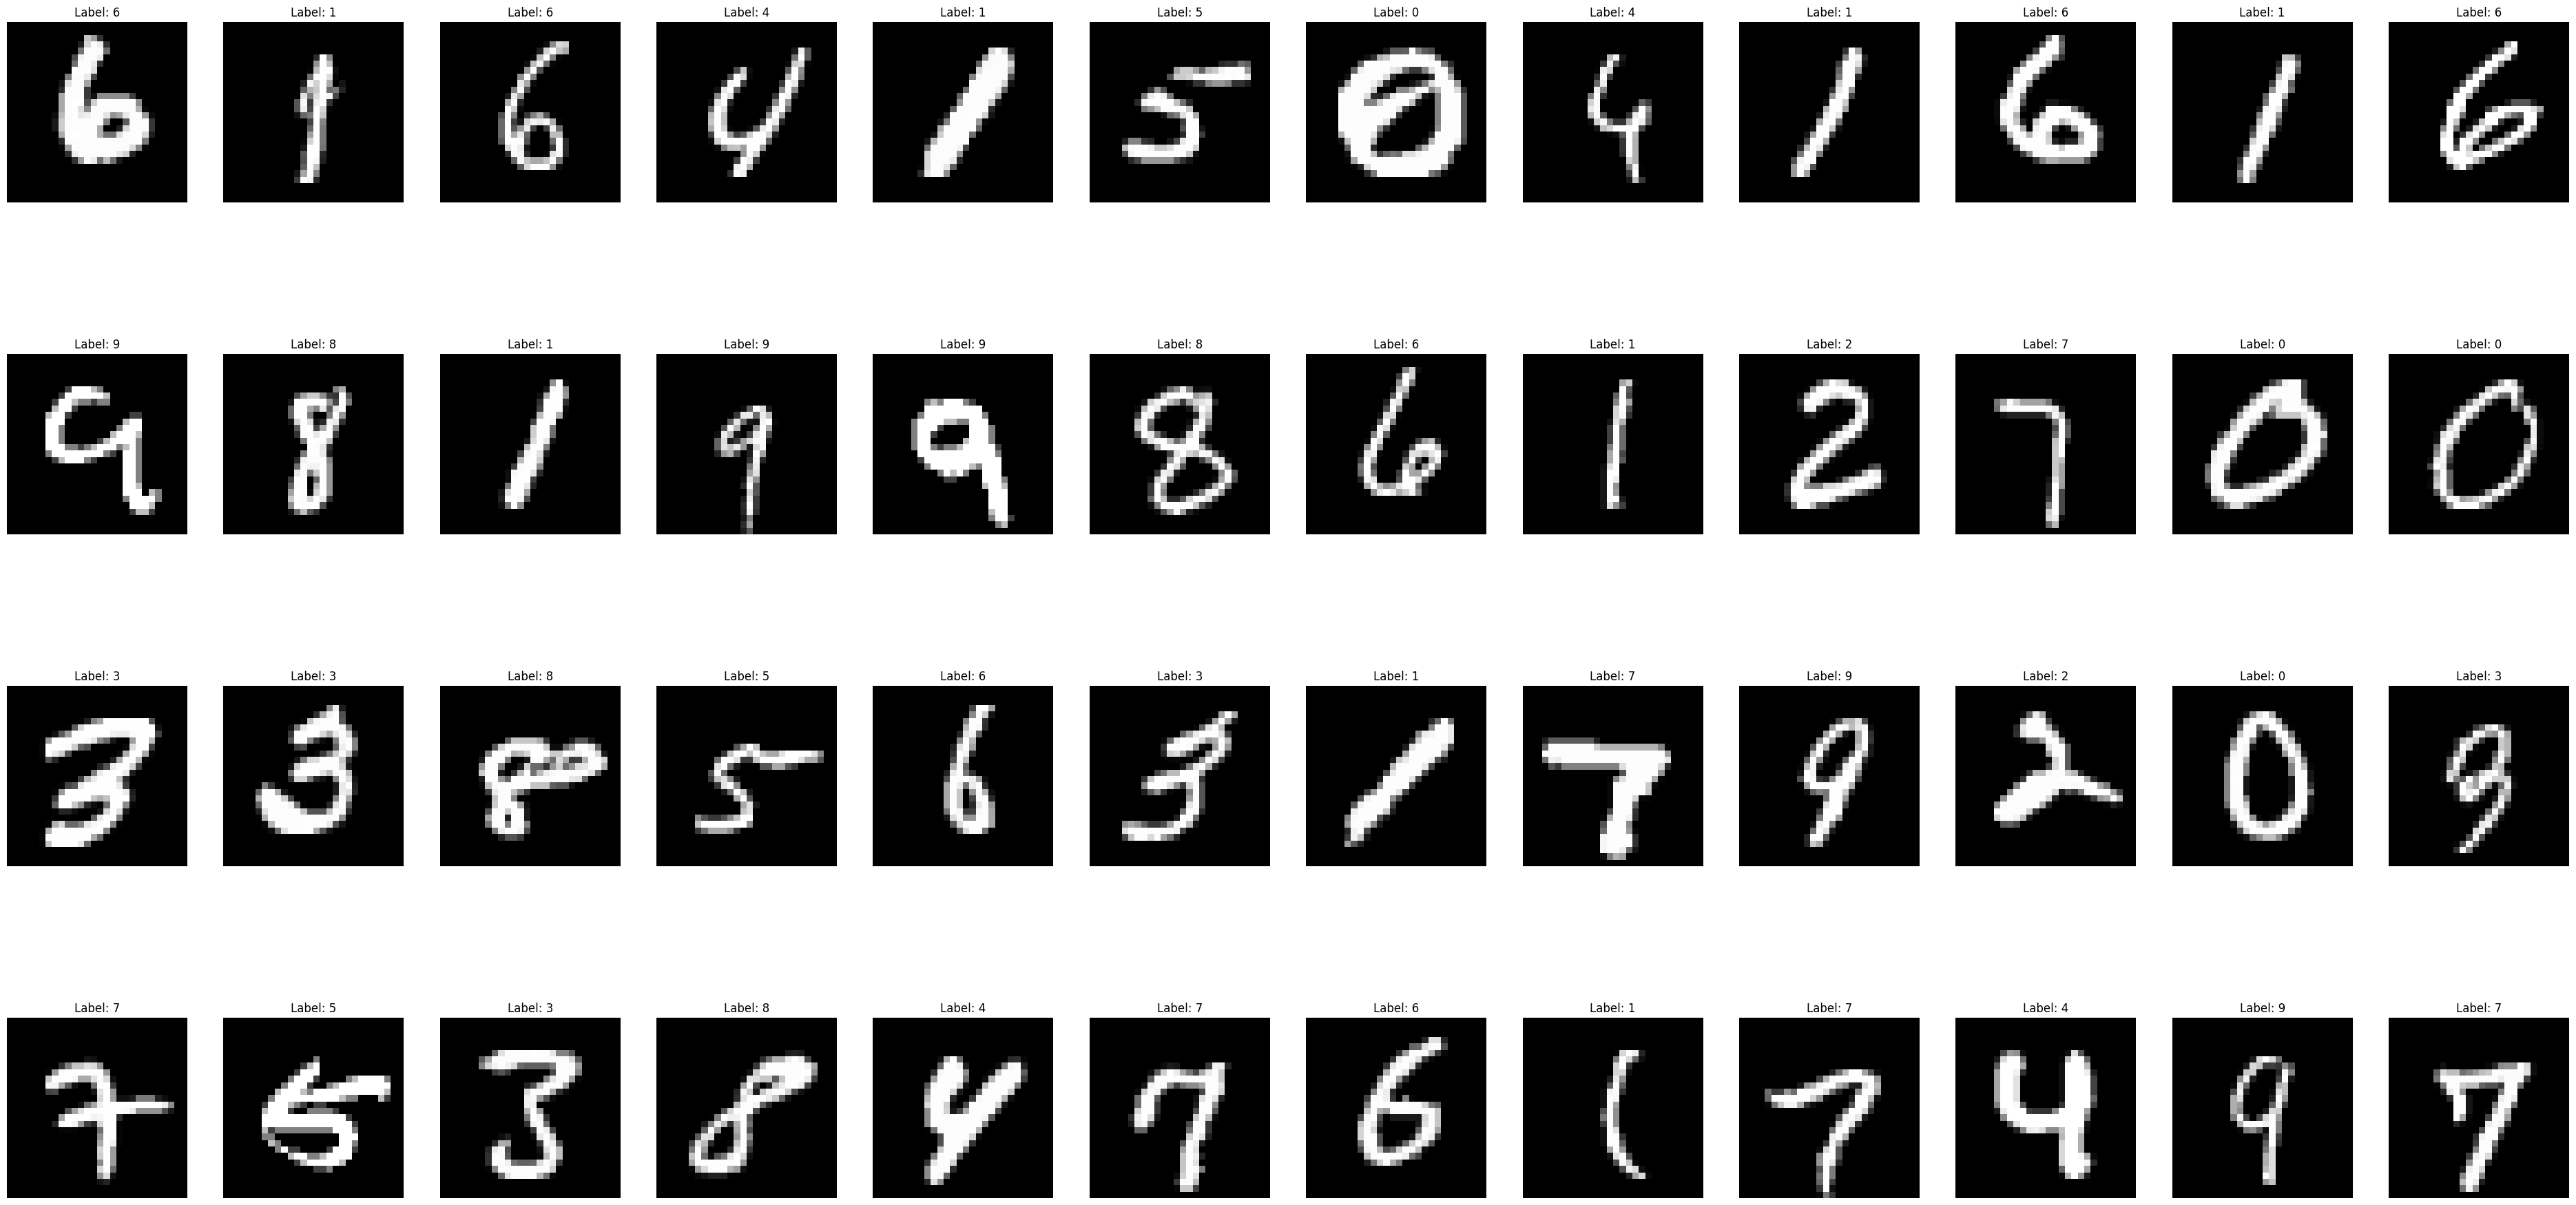

In [3]:
data_iter = iter(train_loader)
num_images = 48
images, labels = next(data_iter)
plt.figure(figsize=(48, 24))
for i in range(num_images):
    plt.subplot(4, 12, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')

## Model Implementation and Training

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20, num_classes=10):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )
        
    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x, c):
        c = nn.functional.one_hot(c, self.num_classes).float()
        
        x = x.view(-1, 784)
        encoder_input = torch.cat([x, c], dim=1)
        encoder_out = self.encoder(encoder_input)
        
        mu, log_var = encoder_out[:, :self.latent_dim], encoder_out[:, self.latent_dim:]
        z = self.reparametrize(mu, log_var)
        
        decoder_input = torch.cat([z, c], dim=1)
        decoder_out = self.decoder(decoder_input)
        return decoder_out, mu, log_var

In [5]:
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = .001
epochs = 200
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
def train(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(data, labels)
            loss = loss_function(recon_batch, data, mu, log_var)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}')

In [8]:
train(model, train_loader, optimizer, epochs)

Epoch 1/200, Loss: 166.2844
Epoch 2/200, Loss: 121.3788
Epoch 3/200, Loss: 112.6903
Epoch 4/200, Loss: 108.3964
Epoch 5/200, Loss: 105.6207
Epoch 6/200, Loss: 103.6795
Epoch 7/200, Loss: 102.2823
Epoch 8/200, Loss: 101.1351
Epoch 9/200, Loss: 100.2464
Epoch 10/200, Loss: 99.4234
Epoch 11/200, Loss: 98.8359
Epoch 12/200, Loss: 98.2263
Epoch 13/200, Loss: 97.7510
Epoch 14/200, Loss: 97.2836
Epoch 15/200, Loss: 96.9057
Epoch 16/200, Loss: 96.5672
Epoch 17/200, Loss: 96.2383
Epoch 18/200, Loss: 95.9310
Epoch 19/200, Loss: 95.6700
Epoch 20/200, Loss: 95.4116
Epoch 21/200, Loss: 95.2384
Epoch 22/200, Loss: 95.0389
Epoch 23/200, Loss: 94.8075
Epoch 24/200, Loss: 94.6580
Epoch 25/200, Loss: 94.4375
Epoch 26/200, Loss: 94.3375
Epoch 27/200, Loss: 94.1577
Epoch 28/200, Loss: 93.9908
Epoch 29/200, Loss: 93.8896
Epoch 30/200, Loss: 93.7129
Epoch 31/200, Loss: 93.6084
Epoch 32/200, Loss: 93.5183
Epoch 33/200, Loss: 93.4160
Epoch 34/200, Loss: 93.2896
Epoch 35/200, Loss: 93.1952
Epoch 36/200, Loss: 

In [9]:
torch.save(model.state_dict(), 'vae_mnist.pth')

## Sample Generation

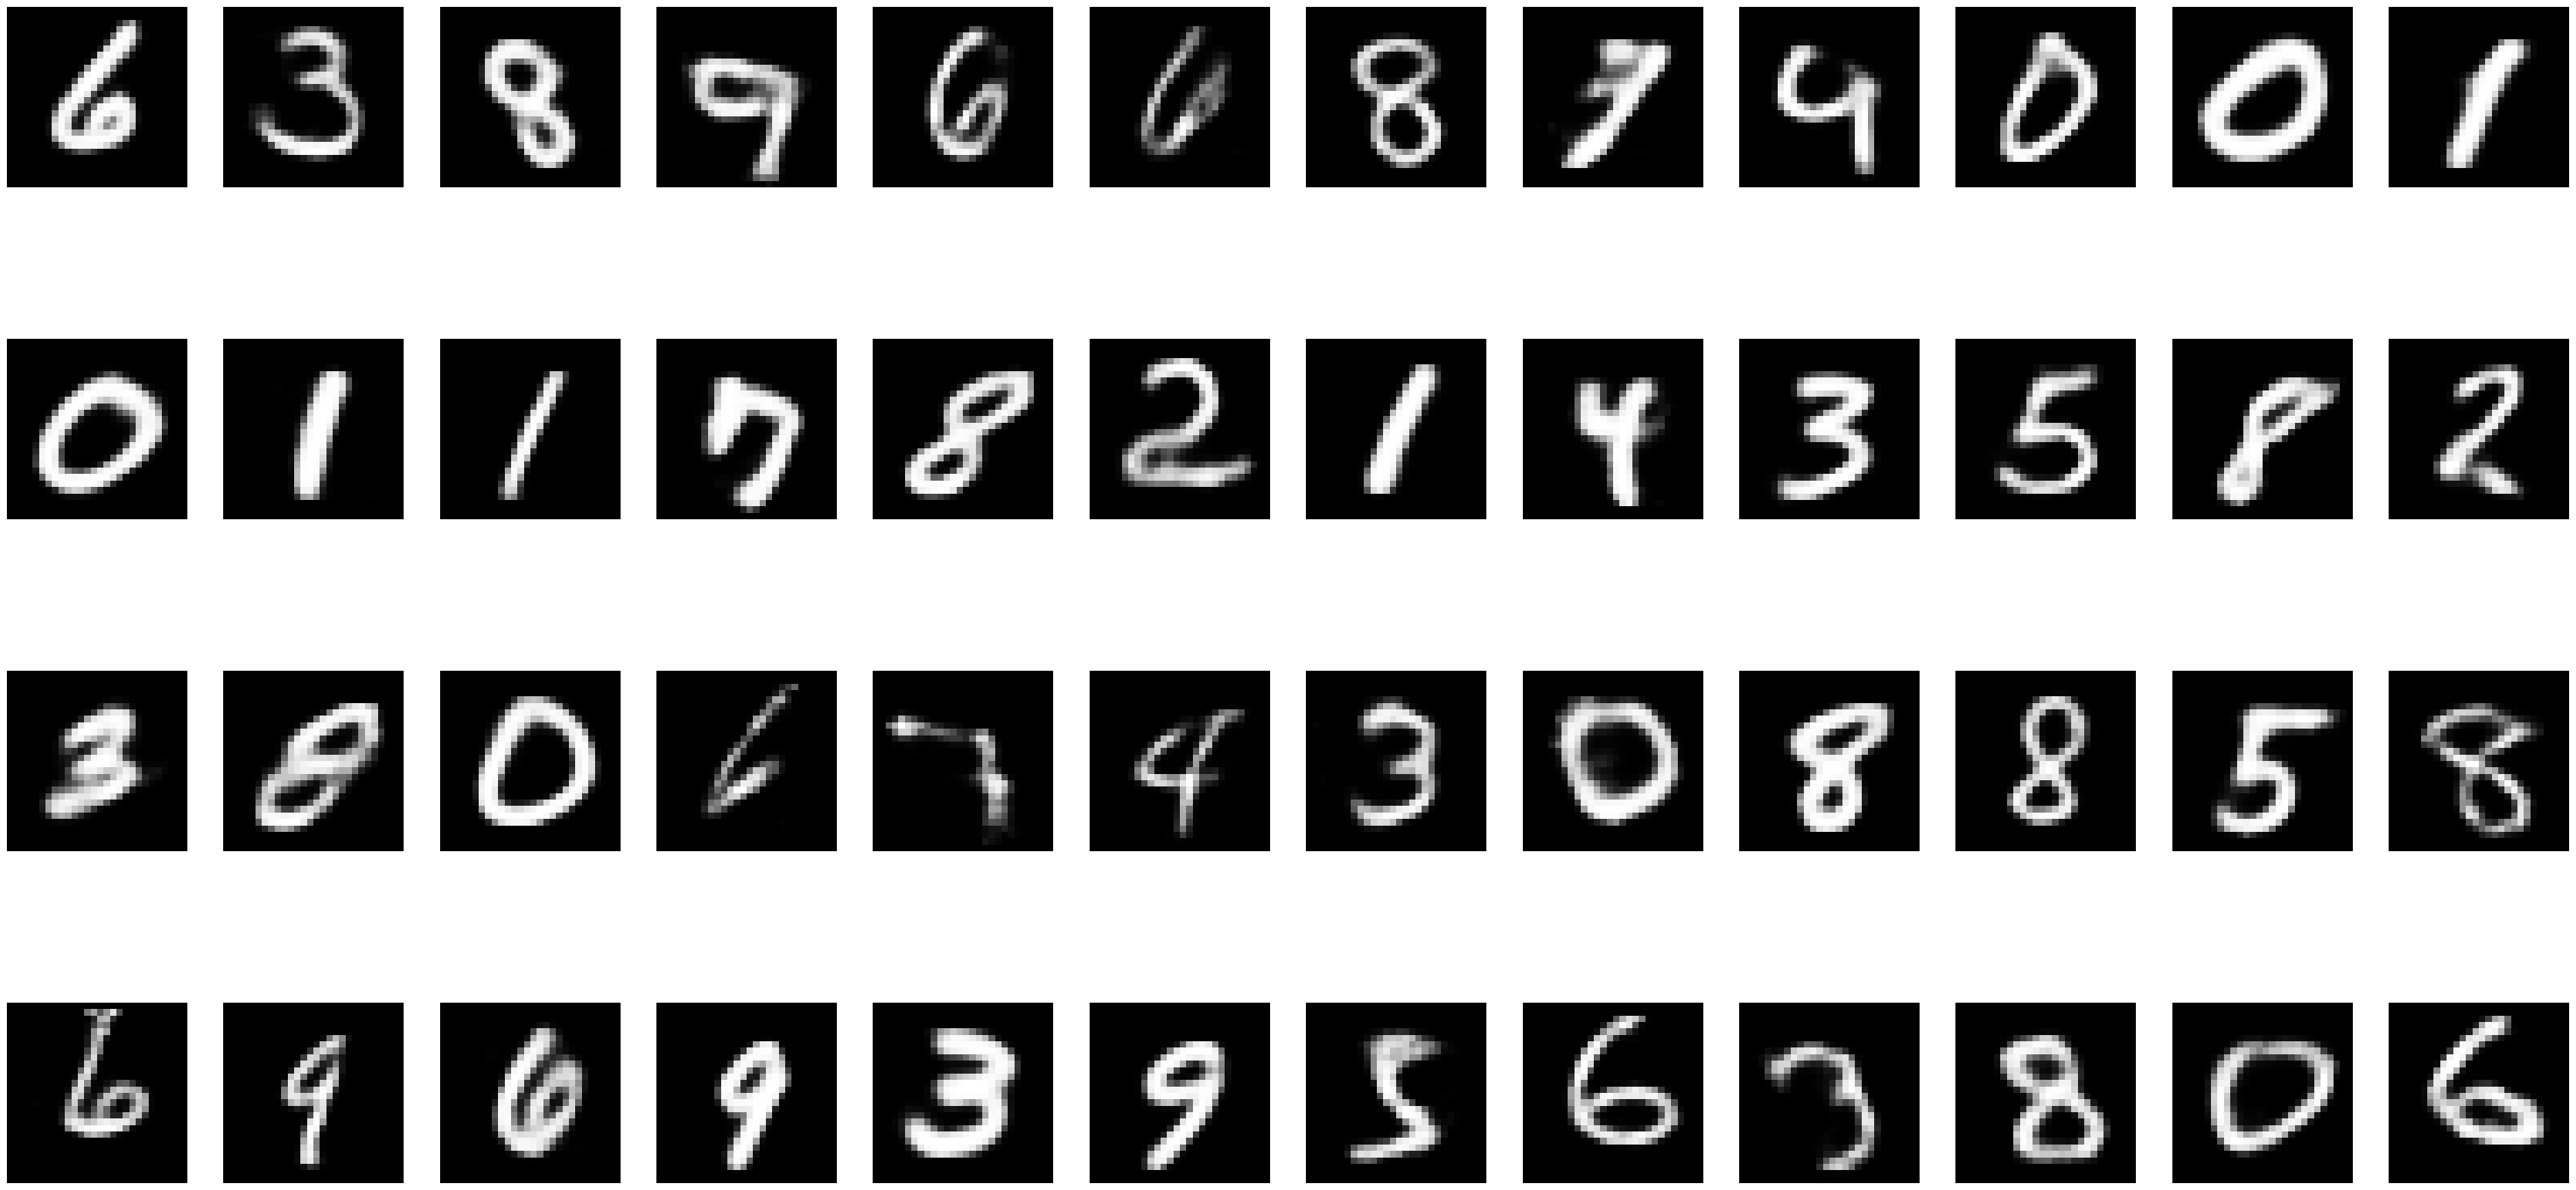

In [10]:
def generate_samples(model, num_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        c = torch.randint(0, 10, (num_samples,)).to(device)
        c_onehot = nn.functional.one_hot(c, 10).float()
        decoder_in = torch.cat([z, c_onehot], dim=1)
        samples = model.decoder(decoder_in)
        return samples.view(-1, 1, 28, 28).cpu()
    
samples = generate_samples(model, 48)
plt.figure(figsize=(48, 24))
for i in range(48):
    plt.subplot(4, 12, i + 1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.axis('off')

## Latent Space Analysis

In [11]:
latent_vectors = {digit: [] for digit in range(10)}
model.eval()

class_indices = {digit: [] for digit in range(10)}
for idx, (data, label) in enumerate(train_set):
    class_indices[label].append(idx)

with torch.no_grad():
    for digit in range(10):
        subset = Subset(train_set, class_indices[digit])
        loader = DataLoader(subset, batch_size=256, shuffle=False)
        
        for images, labels in loader:
            images = images.to(device)
            encoder_in = torch.cat([
                images.view(-1, 784),
                torch.nn.functional.one_hot(labels, 10).float().to(device)
            ], dim=1)
            
            encoder_out = model.encoder(encoder_in)
            mu, log_var = encoder_out[:, :model.latent_dim], encoder_out[:, model.latent_dim:]
            
            latent_vectors[digit].append(mu.cpu().numpy())
        
        latent_vectors[digit] = np.vstack(latent_vectors[digit])
        print(f'Digit {digit}: Collected {latent_vectors[digit].shape[0]} samples')
        
class_areas = {}
class_means = {}
class_covs = {}

for digit in range(10):
    data = latent_vectors[digit]
    
    class_means[digit] = np.mean(data, axis=0)
    
    cov = np.cov(data, rowvar=False)
    cov += 1e-6 * np.eye(cov.shape[0])
    class_covs[digit] = cov
    
    class_areas[digit] = np.linalg.det(cov)
    
    print(f'Digit {digit} area: {class_areas[digit]:.4e}')

print('Class Areas (Spread) in Latent Space:')
for digit, area in sorted(class_areas.items()):
    print(f'Digit {digit}: {area:.4e}')

Digit 0: Collected 5923 samples
Digit 1: Collected 6742 samples
Digit 2: Collected 5958 samples
Digit 3: Collected 6131 samples
Digit 4: Collected 5842 samples
Digit 5: Collected 5421 samples
Digit 6: Collected 5918 samples
Digit 7: Collected 6265 samples
Digit 8: Collected 5851 samples
Digit 9: Collected 5949 samples
Digit 0 area: 5.6599e-32
Digit 1 area: 1.1384e-38
Digit 2 area: 4.0526e-31
Digit 3 area: 3.3169e-31
Digit 4 area: 6.1835e-31
Digit 5 area: 1.9458e-30
Digit 6 area: 4.8494e-32
Digit 7 area: 4.8250e-32
Digit 8 area: 1.3796e-30
Digit 9 area: 3.8727e-32
Class Areas (Spread) in Latent Space:
Digit 0: 5.6599e-32
Digit 1: 1.1384e-38
Digit 2: 4.0526e-31
Digit 3: 3.3169e-31
Digit 4: 6.1835e-31
Digit 5: 1.9458e-30
Digit 6: 4.8494e-32
Digit 7: 4.8250e-32
Digit 8: 1.3796e-30
Digit 9: 3.8727e-32


## Specific Digit Generation

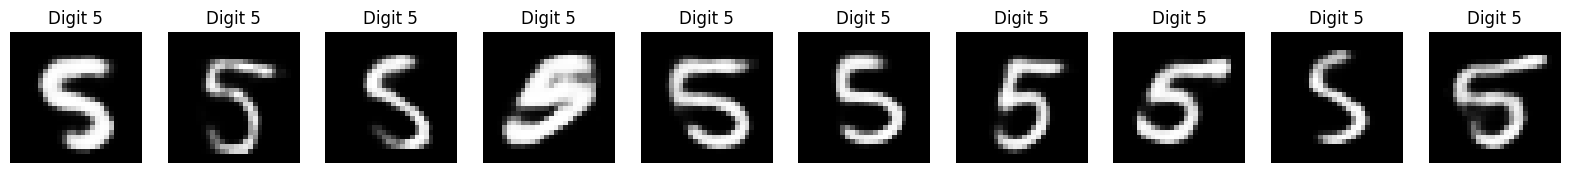

In [12]:
def generate_digit_samples(model, digit, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        c = torch.full((num_samples,), digit).to(device)
        c_onehot = nn.functional.one_hot(c, 10).float()
        decoder_input = torch.cat([z, c_onehot], dim=1)
        samples = model.decoder(decoder_input)
        return samples.view(-1, 1, 28, 28).cpu()

digit_samples = generate_digit_samples(model, digit=5, num_samples=10)
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(digit_samples[i].squeeze().numpy(), cmap='gray')
    ax.set_title(f'Digit 5')
    ax.axis('off')
plt.show()

## Unlearning a Specific Digit
### In this section, we will implement the unlearning process for a specific digit using the method described in the paper. First, we will compute the Fisher Information Matrix (FIM) for the model.

In [13]:
n_fim_samples = 50000

def compute_fisher_information_matrix(model):
    fisher_dict, params_mle_dict = {}, {}
    
    for name, param in model.named_parameters():
        params_mle_dict[name] = param.data.clone()
        fisher_dict[name] = param.data.clone().zero_()
    
    for _ in tqdm.tqdm(range(n_fim_samples)):
        with torch.no_grad():
            z = torch.randn(1, model.latent_dim).to(device)
            c = torch.randint(0, 10, (1,)).to(device)
            c_onehot = nn.functional.one_hot(c, 10).float().to(device)
            model.eval()
            sample = model.decoder(torch.cat([z, c_onehot], dim=1))
            
        model.train()
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(sample, c)
        loss = loss_function(recon_batch, sample, mu, log_var)
        loss.backward()
        
        for name, param in model.named_parameters():
            if torch.isnan(param.grad.data).any():
                print(f'NaN detected in gradients for {name}')
            fisher_dict[name] += param.grad.data ** 2 / n_fim_samples
            
    return fisher_dict, params_mle_dict

In [14]:
fisher_dict, params_mle_dict = compute_fisher_information_matrix(model)

100%|██████████| 50000/50000 [01:15<00:00, 664.21it/s]


### Now we will implement the forgetting process for a specific digit using the Fisher Information Matrix and the Maximum Likelihood Estimation (MLE) parameters.

In [15]:
def forget(model, model_orig, f_digit, fisher_dict, params_mle_dict, device, lambda_ewc=100, gamma=1, epochs=150, batch_size=128):
    remembered_classes = [c for c in range(10) if c != f_digit]
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    for epoch in range(epochs):
        chosen_classes = np.random.choice(remembered_classes, size=batch_size)
        z_remember = torch.randn(batch_size, model.latent_dim).to(device)
        c_remember = torch.tensor(chosen_classes).to(device)
        with torch.no_grad():
            c_remember_onehot = nn.functional.one_hot(c_remember, 10).float()
            decoder_input = torch.cat([z_remember, c_remember_onehot], dim=1)
            x_remember = model_orig.decoder(decoder_input).view(-1, 1, 28, 28)
            
            x_forget = torch.rand((batch_size, 1, 28, 28)).to(device)
            c_forget = torch.full((batch_size,), f_digit).to(device)
        
        optimizer.zero_grad()
        recon_remember, mu_r, logvar_r = model(x_remember, c_remember)
        loss_remember = loss_function(recon_remember, x_remember, mu_r, logvar_r)
        
        recon_forget, mu_f, logvar_f = model(x_forget, c_forget)
        loss_forget = loss_function(recon_forget, x_forget, mu_f, logvar_f)
        
        loss_ewc = 0
        for name, param in model.named_parameters():
            fisher = fisher_dict[name].to(device)
            mle_param = params_mle_dict[name].to(device)
            loss_ewc += (fisher * (param - mle_param).pow(2)).sum()
        
        total_loss = gamma * loss_remember + loss_forget + lambda_ewc * loss_ewc
        total_loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs} | Total Loss: {total_loss.item():.4f}')
    
    return model

In [16]:
model_orig = copy.deepcopy(model)
for param in model_orig.parameters():
    param.requires_grad = False
model_orig.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [17]:
digit_to_forget = 5
unlearned_model = forget(
    model=model,
    model_orig=model_orig,
    f_digit=digit_to_forget,
    fisher_dict=fisher_dict,
    params_mle_dict=params_mle_dict,
    device=device,
    lambda_ewc=100,
    gamma=1,
    epochs=10000,
    batch_size=128
)

Epoch 10/10000 | Total Loss: 854870.1250
Epoch 20/10000 | Total Loss: 650119.3125
Epoch 30/10000 | Total Loss: 481155.9688
Epoch 40/10000 | Total Loss: 366744.3750
Epoch 50/10000 | Total Loss: 284579.8438
Epoch 60/10000 | Total Loss: 217127.5312
Epoch 70/10000 | Total Loss: 166135.6406
Epoch 80/10000 | Total Loss: 131584.7344
Epoch 90/10000 | Total Loss: 108414.9766
Epoch 100/10000 | Total Loss: 98233.8125
Epoch 110/10000 | Total Loss: 94103.2969
Epoch 120/10000 | Total Loss: 94563.1328
Epoch 130/10000 | Total Loss: 92778.0469
Epoch 140/10000 | Total Loss: 92520.4375
Epoch 150/10000 | Total Loss: 92213.0078
Epoch 160/10000 | Total Loss: 91700.2656
Epoch 170/10000 | Total Loss: 91808.7109
Epoch 180/10000 | Total Loss: 91145.4297
Epoch 190/10000 | Total Loss: 91311.1953
Epoch 200/10000 | Total Loss: 91210.0859
Epoch 210/10000 | Total Loss: 90859.1094
Epoch 220/10000 | Total Loss: 90461.2734
Epoch 230/10000 | Total Loss: 90679.7656
Epoch 240/10000 | Total Loss: 90411.1328
Epoch 250/10000 

## Sample Generation After Unlearning

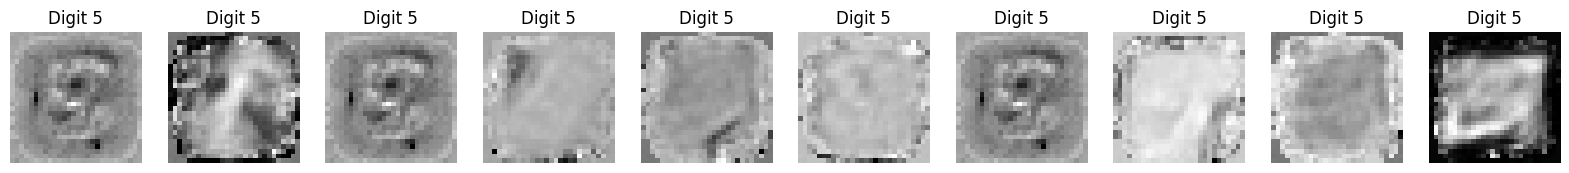

In [18]:
unlearned_samples = generate_digit_samples(unlearned_model, digit=digit_to_forget, num_samples=10)
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(unlearned_samples[i].squeeze().numpy(), cmap='gray')
    ax.set_title(f'Digit {digit_to_forget}')
    ax.axis('off')
plt.show()

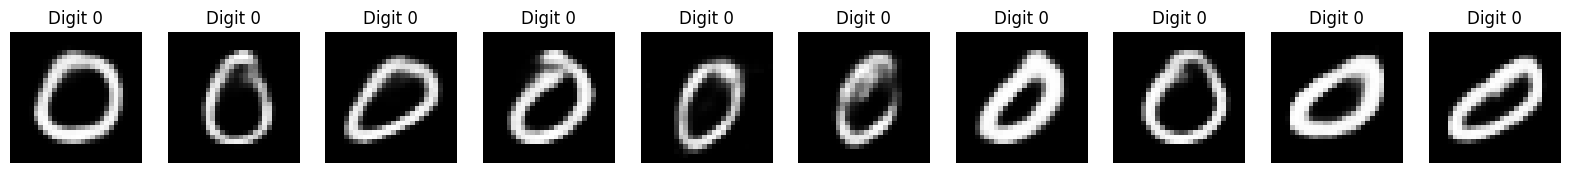

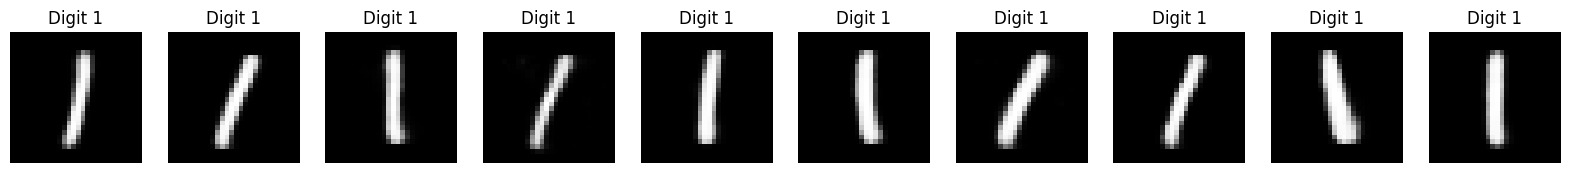

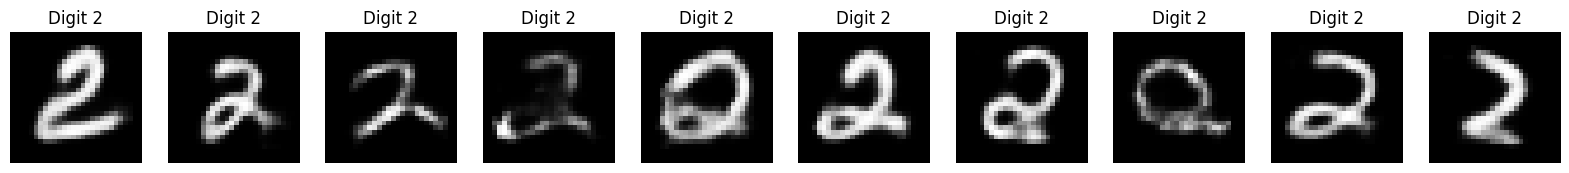

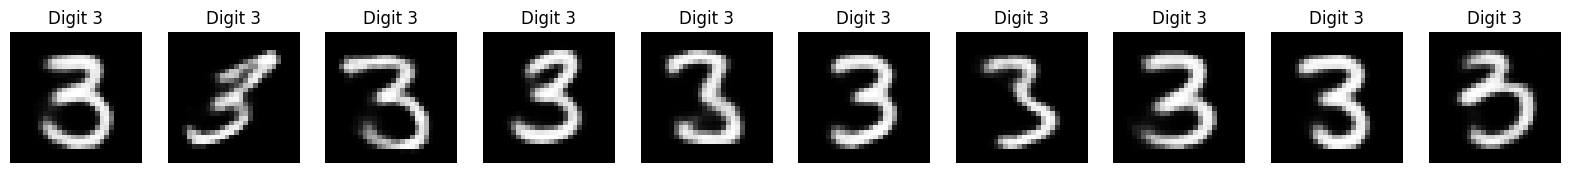

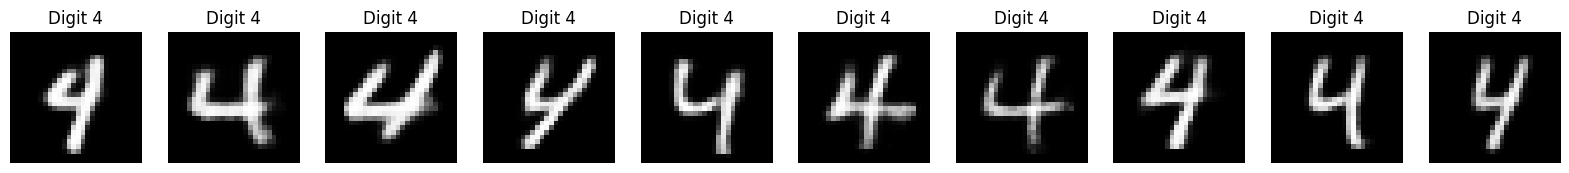

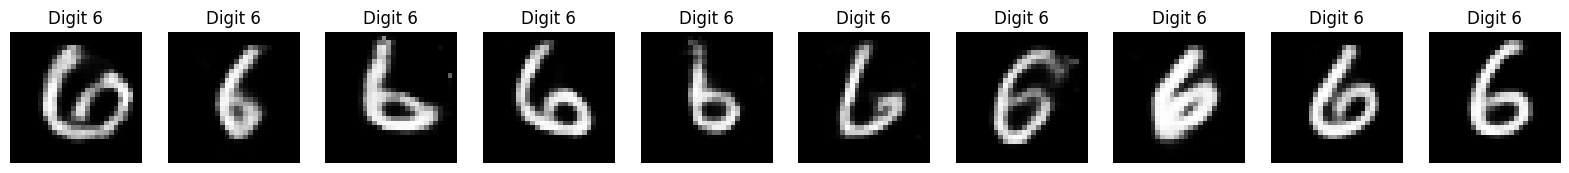

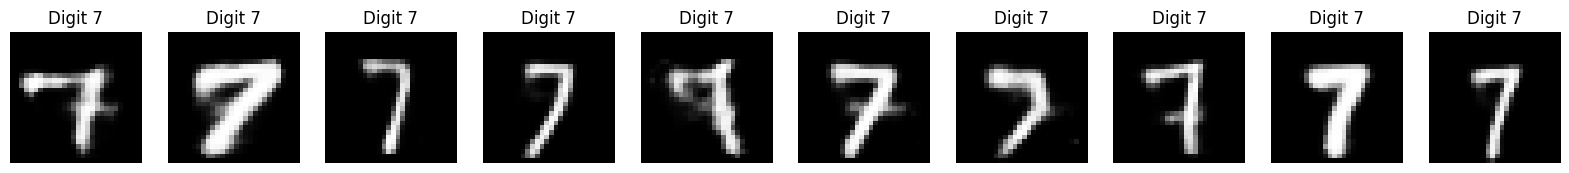

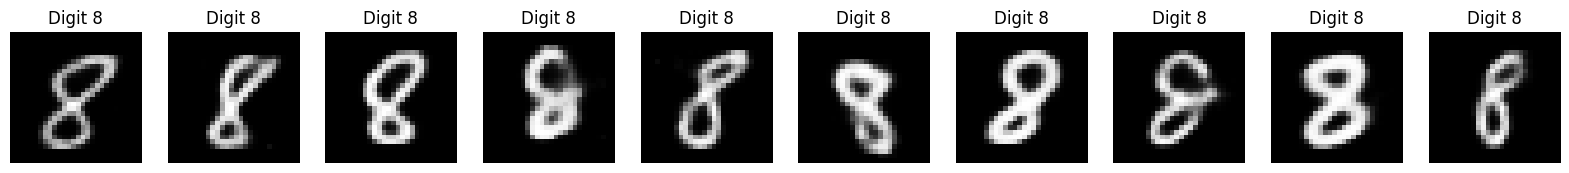

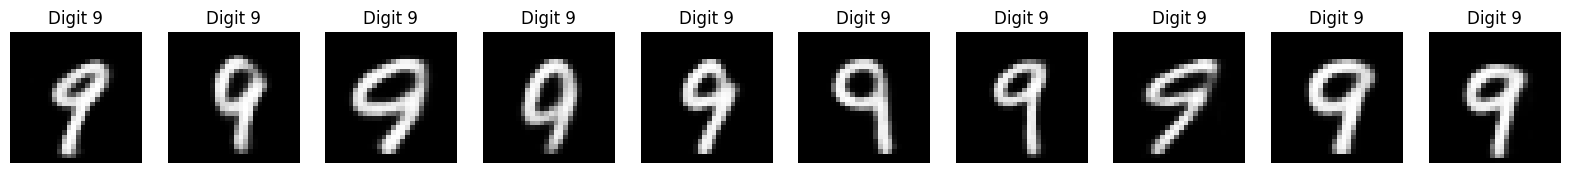

In [19]:
for digit in range(10):
    if digit == digit_to_forget:
        continue
    samples = generate_digit_samples(unlearned_model, digit=digit, num_samples=10)
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i].squeeze().numpy(), cmap='gray')
        ax.set_title(f'Digit {digit}')
        ax.axis('off')
    plt.show()

In [20]:
torch.save(unlearned_model.state_dict(), 'vae_mnist_unlearned.pth')